## Importing the packages

In [21]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Importing the data

In [22]:
data = pd.read_csv('data.csv')
df = data.copy()
df.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


## Checking null value

In [23]:
df.isnull().sum()

,0
Month,0
Thousands of Passengers,1


In [24]:
df.tail()

,Month,Thousands of Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


## Dropping the null value

In [25]:
df.dropna(axis=0, inplace=True)

In [26]:
df.isnull().sum()

,0
Month,0
Thousands of Passengers,0


## Checking the dataset information

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


## Converting the "Month" column into datetime

In [28]:
df['Month'] = pd.to_datetime(df['Month'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [30]:
df.head()

,Month,Thousands of Passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


## Setting the "Month" column as the index

In [33]:
df.set_index('Month', inplace=True)

In [34]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: xlabel='Month'>

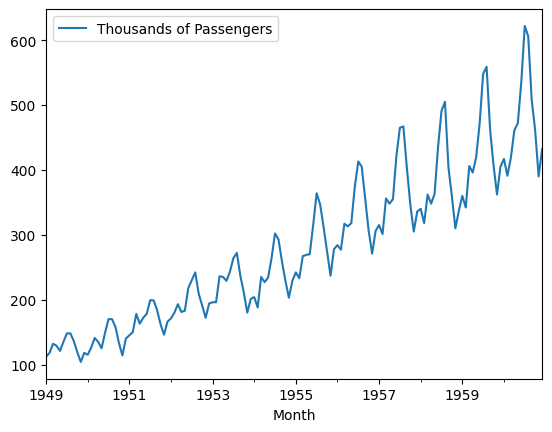

In [35]:
df.plot()

## Doing "Dickey Fuller" test to determine the P value so that we can determine if the data is stationary or not

In [36]:
from statsmodels.tsa.stattools import adfuller

In [49]:
def adf_test(column) -> str:
  result = adfuller(column)
  print(f"ADF Statistic: {format(result[0])}")
  print(f"P-value: {format(result[1])}")
  if result[1] <= 0.05:
    print("The data is STATIONARY")
  else:
    print("The data is NOT STATIONARY")


In [50]:
adf_test(df['Thousands of Passengers'])

ADF Statistic: 0.8153688792060498
P-value: 0.991880243437641
The data is NOT STATIONARY


## To make the data STATIONARY we will do DIFFERENCING

In [51]:
df["Passenger_first_difference"] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(1)

In [52]:
df.head()

,Thousands of Passengers,Passenger_first_difference
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,6.0
1949-03-01,132.0,14.0
1949-04-01,129.0,-3.0
1949-05-01,121.0,-8.0


## Now we will do the adf_test for the new column we created, if it is a stationary data or not

In [56]:
adf_test(df['Passenger_first_difference'].dropna())

ADF Statistic: -2.8292668241700047
P-value: 0.05421329028382478
The data is NOT STATIONARY


## Still the data is not stationary so we will now do another shift/differencing

In [57]:
df['Passenger_Second_difference'] = df['Passenger_first_difference'] - df['Passenger_first_difference'].shift(1)

In [58]:
df.head()

,Thousands of Passengers,Passenger_first_difference,Passenger_Second_difference
Month,,,
1949-01-01,112.0,NaN,NaN
1949-02-01,118.0,6.0,NaN
1949-03-01,132.0,14.0,8.0
1949-04-01,129.0,-3.0,-17.0
1949-05-01,121.0,-8.0,-5.0


In [59]:
adf_test(df['Passenger_Second_difference'].dropna())

ADF Statistic: -16.384231542468513
P-value: 2.7328918500142026e-29
The data is STATIONARY


## As it is a seasonal data so we will see the data is stationary or not for 12 shifts i.e. for the whole year

In [60]:
df['Passenger_12_difference'] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(12)

In [61]:
adf_test(df['Passenger_12_difference'].dropna())

ADF Statistic: -3.383020726492481
P-value: 0.011551493085514952
The data is STATIONARY


## NOTE: For the seasonal data if ARIMA does not give us good result i.e. if for 12 shifts if it would give us non stationary data then we had to use SARIMA model

## Plotting ACF and PACF graph.

By that graphs we can see the upper bound and lower bound lines and can see the P value from that

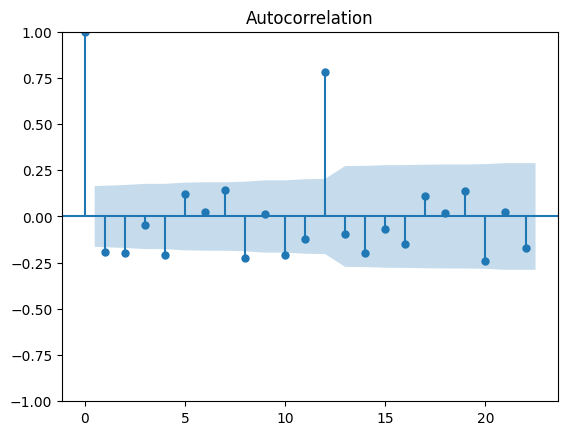

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_seasonal = plot_acf(df['Passenger_Second_difference'].dropna())

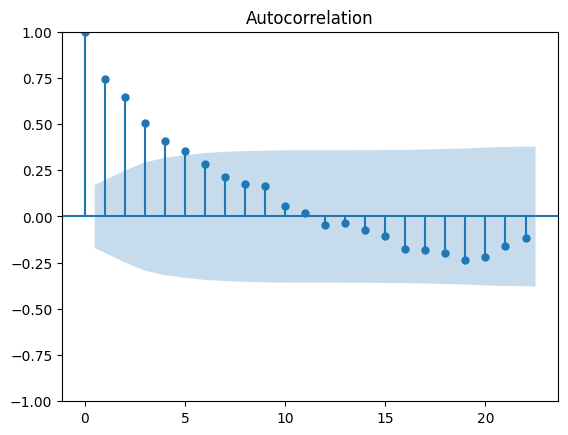

In [91]:
### Seasonal
acf_seasonal = plot_acf(df['Passenger_12_difference'].dropna())

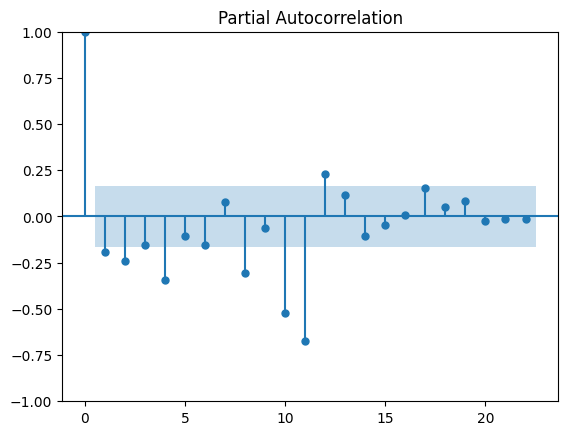

In [92]:
### PACF
pacf = plot_pacf(df['Passenger_Second_difference'].dropna())


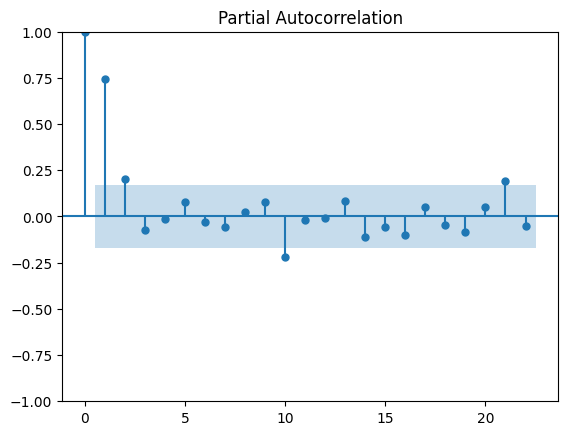

In [93]:
### PACF Seasonal
pacf_seasonal = plot_pacf(df['Passenger_12_difference'].dropna())

## Train test split

In [78]:
df

,Thousands of Passengers,Passenger_first_difference,Passenger_Second_difference,Passenger_12_difference
Month,,,,
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,6.0,NaN,NaN
1949-03-01,132.0,14.0,8.0,NaN
1949-04-01,129.0,-3.0,-17.0,NaN
1949-05-01,121.0,-8.0,-5.0,NaN
...,...,...,...,...
1960-08-01,606.0,-16.0,-103.0,47.0
1960-09-01,508.0,-98.0,-82.0,45.0
1960-10-01,461.0,-47.0,51.0,54.0


In [79]:
from datetime import datetime, timedelta
train_dataset_end = datetime(1955,12,1)
test_dataset_end = datetime(1960,12,1)

In [81]:
train_data = df[:train_dataset_end]
test_data = df[train_dataset_end+timedelta(days=1): test_dataset_end]

In [86]:
test_data

,Thousands of Passengers,Passenger_first_difference,Passenger_Second_difference,Passenger_12_difference
Month,,,,
1956-01-01,284.0,6.0,-35.0,42.0
1956-02-01,277.0,-7.0,-13.0,44.0
1956-03-01,317.0,40.0,47.0,50.0
1956-04-01,313.0,-4.0,-44.0,44.0
1956-05-01,318.0,5.0,9.0,48.0
1956-06-01,374.0,56.0,51.0,59.0
1956-07-01,413.0,39.0,-17.0,49.0
1956-08-01,405.0,-8.0,-47.0,58.0
1956-09-01,355.0,-50.0,-42.0,43.0


## creating ARIMA model

In [87]:
from statsmodels.tsa.arima.model import ARIMA

In [88]:
train_data

,Thousands of Passengers,Passenger_first_difference,Passenger_Second_difference,Passenger_12_difference
Month,,,,
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,6.0,NaN,NaN
1949-03-01,132.0,14.0,8.0,NaN
1949-04-01,129.0,-3.0,-17.0,NaN
1949-05-01,121.0,-8.0,-5.0,NaN
...,...,...,...,...
1955-08-01,347.0,-17.0,-66.0,54.0
1955-09-01,312.0,-35.0,-18.0,53.0
1955-10-01,274.0,-38.0,-3.0,45.0


In [95]:
### Applying ARIMA model
model_ARIMA = ARIMA(train_data['Thousands of Passengers'], order=(10,2,0))
## order(10,2,0) is the p,d,q value respectively, we are taking the second shift data. and making the MA as 0, or else it will be seasonal so,
## we will be needing SARIMA then

In [96]:
model_arima = model_ARIMA.fit()

In [97]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   84
Model:                     ARIMA(10, 2, 0)   Log Likelihood                -357.239
Date:                     Wed, 02 Apr 2025   AIC                            736.477
Time:                             17:52:53   BIC                            762.951
Sample:                         01-01-1949   HQIC                           747.106
                              - 12-01-1955                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5166      0.121     -4.262      0.000      -0.754      -0.279
ar.L2         -0.7204      0.121     -5.940      0.000      -0.958      -0.483
ar.L3         -0.4857      0.125     -3.876      0.000      -0.731      -0.240
ar.L4         -0.7505      0.129     -5.819      0.000      -1.003      -0.498
ar.L5         -0.5062      0.169     -2.991      0.003      -0.838      -0.175
ar.L6         -0.5200      0.141     -3.683      0.000      -0.797      -0.243
ar.L7         -0.3051      0.143     -2.127      0.033      -0.586      -0.024
ar.L8         -0.5939      0.155     -3.833      0.000      -0.898      -0.290
ar.L9         -0.2963      0.132     -2.241      0.025      -0.555      -0.037
ar.L10        -0.4825      0.110     -4.376      0.000      -0.699      -0.266
sigma2       336.0939     66.064      5.087      0.000     206.612     465.576
===================================================================================
Ljung-Box (L1) (Q):                  10.86   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.00   Prob(JB):                         0.54
Heteroskedasticity (H):               2.85   Skew:                             0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction

In [99]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(f"Prediction start date: {pred_start_date}")
print(f"Prediction end date: {pred_end_date}")

Prediction start date: 1956-01-01 00:00:00
Prediction end date: 1960-12-01 00:00:00


In [100]:
pred = model_arima.predict(start=pred_start_date, end=pred_end_date)

In [103]:
test_data['Predicted_ARIMA']=pred

<Axes: xlabel='Month'>

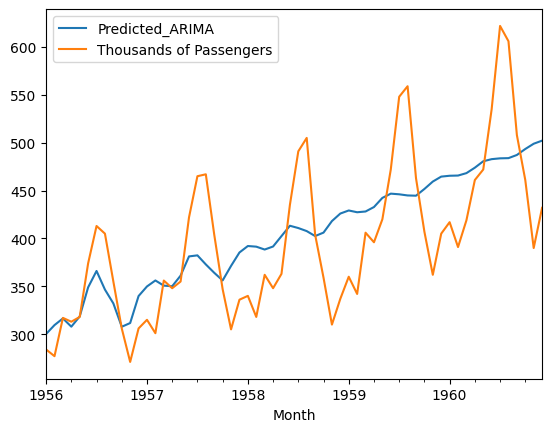

In [105]:
test_data[['Predicted_ARIMA', 'Thousands of Passengers']].plot()

## Applying SARIMAX model as Seasonality is there

In [116]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_SARIMAX = SARIMAX(train_data['Thousands of Passengers'], order=(3,0,5), seasonal_order=(3,0,5,12))

In [117]:
model_sarimax = model_SARIMAX.fit()

In [118]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Thousands of Passengers   No. Observations:                   84
Model:             SARIMAX(3, 0, 5)x(3, 0, 5, 12)   Log Likelihood                -318.295
Date:                            Wed, 02 Apr 2025   AIC                            670.590
Time:                                    18:46:24   BIC                            711.914
Sample:                                01-01-1949   HQIC                           687.202
                                     - 12-01-1955                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5111      0.425     -1.201      0.230      -1.345       0.323
ar.L2          0.7413      0.193      3.834      0.000       0.362       1.120
ar.L3          0.7517      0.401      1.873      0.061      -0.035       1.538
ma.L1          1.3330      0.415      3.215      0.001       0.520       2.146
ma.L2          0.5340      0.420      1.272      0.204      -0.289       1.357
ma.L3         -0.3515      0.247     -1.425      0.154      -0.835       0.132
ma.L4         -0.3801      0.238     -1.598      0.110      -0.847       0.086
ma.L5         -0.2726      0.174     -1.570      0.116      -0.613       0.068
ar.S.L12       1.1307      3.284      0.344      0.731      -5.306       7.567
ar.S.L24      -0.0431      1.637     -0.026      0.979      -3.252       3.166
ar.S.L36      -0.1950      1.603     -0.122      0.903      -3.337       2.947
ma.S.L12      -0.1968     17.208     -0.011      0.991     -33.925      33.531
ma.S.L24       0.0098     31.093      0.000      1.000     -60.930      60.950
ma.S.L36      -0.0238     27.709     -0.001      0.999     -54.332      54.285
ma.S.L48      -0.3117     26.188     -0.012      0.991     -51.639      51.015
ma.S.L60       0.9176     38.928      0.024      0.981     -75.380      77.215
sigma2        48.7004   2039.567      0.024      0.981   -3948.777    4046.177
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 2.11
Prob(Q):                              0.75   Prob(JB):                         0.35
Heteroskedasticity (H):               2.94   Skew:                             0.38
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:
model_sarimax_predict = model_sarimax.predict(start=pred_start_date, end=pred_end_date)

In [120]:
test_data['SARIMAX_predicted'] = model_sarimax_predict

In [121]:
test_data

,Thousands of Passengers,Passenger_first_difference,Passenger_Second_difference,Passenger_12_difference,Predicted_ARIMA,SARIMAX_predicted
Month,,,,,,
1956-01-01,284.0,6.0,-35.0,42.0,300.183612,292.864796
1956-02-01,277.0,-7.0,-13.0,44.0,309.478355,281.384381
1956-03-01,317.0,40.0,47.0,50.0,316.443015,319.577677
1956-04-01,313.0,-4.0,-44.0,44.0,307.827544,314.883731
1956-05-01,318.0,5.0,9.0,48.0,318.544234,324.893129
1956-06-01,374.0,56.0,51.0,59.0,348.922083,358.250222
1956-07-01,413.0,39.0,-17.0,49.0,366.020287,404.425956
1956-08-01,405.0,-8.0,-47.0,58.0,346.567534,386.519386
1956-09-01,355.0,-50.0,-42.0,43.0,332.120969,355.586529


<Axes: xlabel='Month'>

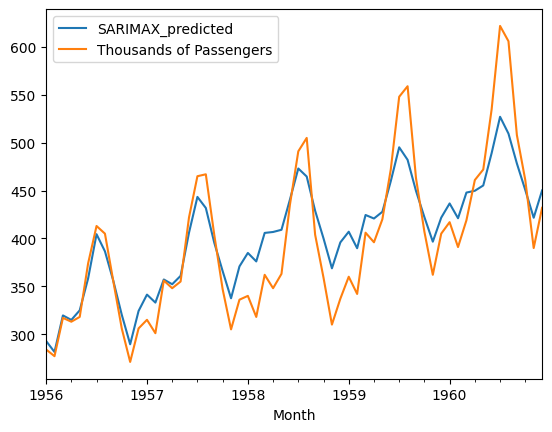

In [124]:
test_data[['SARIMAX_predicted', 'Thousands of Passengers']].plot()

## OBSERVATION:
Whenever seasonality will be there in the data, ARIMA will not perform well, in this case also SARIMAX gives us better results.
